# NeuralHD - Paper Ready Script

## Preparation:

### Note: Config.py handle all configuration of the model, including data_location, the directory in which data is stored.

In [9]:
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import time
import sys
import math
import numpy as np
import random
import joblib
from tqdm import tqdm_notebook
import copy

import Config
import Dataloader as DL
import HD_basis as HDB
import HD_encoder as HDE
import HD_classifier as HDC

import matplotlib.pyplot as plt


In [10]:
# train data 
def train(hdc, traindata, trainlabels, testdata, testlabels, param = Config.config, epochs = None):
    train_acc = []
    test_acc = []
    if epochs is not None:
        param["epochs"] = epochs
    #for i in tqdm_notebook(range(param["epochs"]), desc='epochs'):
    for i in range(param["epochs"]):
        train_acc.append(hdc.fit(traindata, trainlabels, param))
        test_acc.append(hdc.test(testdata, testlabels))
        if len(train_acc) % 20 == 0:
            print("Train: %f \t \t Test: %f"%(train_acc[-1], test_acc[-1]))
        if train_acc[-1] == 1:
            print("Training converged!") 
            print("Train: %f \t \t Test: %f"%(train_acc[-1], test_acc[-1]))
            break
    return np.asarray(train_acc), np.asarray(test_acc), i

In [11]:
def dump_log(param, train_acc, test_acc, filename):
    joblib.dump((param, train_acc, test_acc), open(filename+".pkl", "wb"), compress=True)
    file = open(filename+".txt", "w")
    file.write("Max train: %.2f \tMax test: %.2f \n"%(train_acc*100, test_acc*100))
    file.write(str(param))
    file.close()

In [12]:
dl = DL.Dataloader()
nFeatures, nClasses, traindata, trainlabels, testdata, testlabels = dl.getParam()

Loading dataset smart_home_split from smart_home
Loading train data... train data of shape (22290, 312) loaded
Loading test data...  test  data of shape (5574, 312) loaded
Data Loaded. Num of features = 312 Num of Classes = 3

In [13]:
#Data shuffling 
shuf_train = np.random.permutation(len(traindata))
traindata = traindata[shuf_train]
trainlabels = trainlabels[shuf_train]

shuf_test = np.random.permutation(len(testdata))
testdata = testdata[shuf_test]
testlabels = testlabels[shuf_test]

In [14]:
param = Config.config
param["nFeatures"] = nFeatures
param["nClasses"] = nClasses
print(param)

{'data_location': './dataset/', 'directory': 'smart_home', 'dataset': 'smart_home_split', 'D': 200, 'vector': 'Gaussian', 'mu': 0, 'sigma': 1, 'binarize': 0, 'lr': 0.037, 'sparse': 0, 's': 0.1, 'binaryModel': 0, 'checkpoints': False, 'width': None, 'height': None, 'nLayers': 5, 'uniform_dim': 1, 'uniform_ker': 1, 'dArr': None, 'k': 3, 'kArr': None, 'one_shot': 0, 'data_percentages': [1.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5], 'train_percent': 1, 'dropout': 0, 'drop_percentages': [0, 0.1, 0.2, 0.5], 'dropout_rate': 0, 'update_type': <Update_T.FULL: 1>, 'masked': False, 'iter_per_trial': 3, 'iter_per_encoding': 5, 'epochs': 250, 'nFeatures': 312, 'nClasses': 3}


# Baseline Automation 

## In this section we run multiple baseline models, varying on the hyperdimensions


In [15]:
## Baseline Automation: 

log = []

#for D in [100, 200, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000]:
for D in [2000]:
    param["D"] = D
    hdb = HDB.HD_basis(HDB.Generator.Vanilla, param)
    basis = hdb.getBasis()
    param = hdb.getParam()
    hde = HDE.HD_encoder(basis)
    trainencoded = hde.encodeData(traindata)
    testencoded = hde.encodeData(testdata)
    hdc_pre = HDC.HD_classifier(param["D"], param["nClasses"], 0)
    train_accs_pre, test_accs_pre, num_iter = train(hdc_pre, trainencoded, trainlabels, testencoded, testlabels, param)
    print("Train: %f \t \t Test: %f Number of iterations: %f"%(max(train_accs_pre), max(test_accs_pre), num_iter))
    log.append((D, max(train_accs_pre), max(test_accs_pre), num_iter))

Train: 0.986810 	 	 Test: 0.965196
Train: 0.992642 	 	 Test: 0.973986
Train: 0.998834 	 	 Test: 0.975063
Training converged!
Train: 1.000000 	 	 Test: 0.975601
Train: 1.000000 	 	 Test: 0.976139 Number of iterations: 66.000000


In [16]:
print(log)
for (D, t1, t2, it) in log:
    print("Test accuracy: ", t2)
print("##################")
for (D, t1, t2, it) in log:
    print("Number of iteration: ", it)

[(2000, 1.0, 0.9761392177969143, 66)]
Test accuracy:  0.9761392177969143
##################
Number of iteration:  66


# Dimension Dropping 

## In this section we measure the performance of the model given the following modification

### 1. Drop dimensions from the lowest variance: This should give highest accuracy at each drop rate
### 2. Drop dimensions from the highest variance: This should give lowest accuracy 
### 3. Drop dimensions randomly

In [18]:
# Generate a base model

hdb = HDB.HD_basis(HDB.Generator.Vanilla, param)
basis = hdb.getBasis()
param = hdb.getParam()
hde = HDE.HD_encoder(basis)
trainencoded = hde.encodeData(traindata)
testencoded = hde.encodeData(testdata)
hdc_pre = HDC.HD_classifier(param["D"], param["nClasses"], 0)
train_accs_pre, test_accs_pre, num_iter = train(hdc_pre, trainencoded, trainlabels, testencoded, testlabels, param)

oghdc = copy.deepcopy(hdc_pre)
var, orders = oghdc.evaluateBasis()

Train: 0.982862 	 	 Test: 0.973448
Train: 0.993899 	 	 Test: 0.974166
Train: 0.997039 	 	 Test: 0.973628
Training converged!
Train: 1.000000 	 	 Test: 0.974345


In [19]:
D = oghdc.D    

bl = oghdc.test(testencoded, testlabels)

los = []
lo_hdc = copy.deepcopy(oghdc)
for dr in range(1, 51, 1):

    drop_rate = dr/100
    amountDrop = int(drop_rate * D)
    
    lo_idx = orders[:amountDrop]
    #lo_var = [var[idx] for idx in lo_idx]
    lo_hdc.updateClasses(lo_idx)
    lo_acc = lo_hdc.test(testencoded, testlabels)
    los.append(lo_acc)


his = []
hi_hdc = copy.deepcopy(oghdc)
for dr in range(1, 51, 1):
    
    drop_rate = dr/100
    amountDrop = int(drop_rate * D)
    
    hi_idx = orders[-amountDrop:]
    #hi_var = [var[idx] for idx in hi_idx]
    hi_hdc.updateClasses(hi_idx)
    hi_acc = hi_hdc.test(testencoded, testlabels)
    his.append(hi_acc)
    
    
rds = []
rd_hdc = copy.deepcopy(oghdc)
rd_perm = np.random.permutation(D)
for dr in range(1, 51, 1):
    
    drop_rate = dr/100
    amountDrop = int(drop_rate * D)
    
    rd_idx = rd_perm[:amountDrop]
    #rd_var = [var[idx] for idx in rd_idx]
    rd_hdc.updateClasses(rd_idx)
    rd_acc = rd_hdc.test(testencoded, testlabels)
    rds.append(rd_acc)

In [72]:
#print(los)
#print(his)
#print(rds)

print("Accuracy of Baseline ##############")
print(bl)
print("Drop from low  Variance #############")
for i, lo in enumerate(los):
    print("Drop rate: %0.2f, Accuracy: %.6f"%( i / 100,lo))
print("Drop from high Variance ############")
for i, hi in enumerate(his):
    print("Drop rate: %0.2f, Accuracy: %.6f"%( i / 100,hi))
print("Drop Randomly #################################")
for i, rd in enumerate(rds):
    print("Drop rate: %0.2f, Accuracy: %.6f"%( i / 100,rd))



Accuracy of Baseline ##############
0.9727305346250449
Drop from low  Variance #############
Drop rate: 0.00, Accuracy: 0.972731
Drop rate: 0.01, Accuracy: 0.972910
Drop rate: 0.02, Accuracy: 0.973448
Drop rate: 0.03, Accuracy: 0.971475
Drop rate: 0.04, Accuracy: 0.971475
Drop rate: 0.05, Accuracy: 0.971116
Drop rate: 0.06, Accuracy: 0.971475
Drop rate: 0.07, Accuracy: 0.971295
Drop rate: 0.08, Accuracy: 0.970936
Drop rate: 0.09, Accuracy: 0.971654
Drop rate: 0.10, Accuracy: 0.972192
Drop rate: 0.11, Accuracy: 0.971475
Drop rate: 0.12, Accuracy: 0.969142
Drop rate: 0.13, Accuracy: 0.966272
Drop rate: 0.14, Accuracy: 0.969681
Drop rate: 0.15, Accuracy: 0.966272
Drop rate: 0.16, Accuracy: 0.963043
Drop rate: 0.17, Accuracy: 0.961787
Drop rate: 0.18, Accuracy: 0.967887
Drop rate: 0.19, Accuracy: 0.967528
Drop rate: 0.20, Accuracy: 0.967528
Drop rate: 0.21, Accuracy: 0.966451
Drop rate: 0.22, Accuracy: 0.966990
Drop rate: 0.23, Accuracy: 0.965375
Drop rate: 0.24, Accuracy: 0.958916
Drop ra

# NeuralHD train (automation): train NeuralHD untill the effective dimension if reached. 

In [20]:

# Given listed parameters, generate a NeuralHD model + best model during train
# Train method: train till an effective dimension 
def train_neural_ed(traindata, trainlabels, testdata, testlabels,
                   D, # initial baseline
                   eDs,  # list of effective dimensions to reach 
                   percentDrop, # drop/regen rate 
                   iter_per_update, # # iterations per regen  
                   param):

    param["D"] = D
    
    # Initialize basis & classifier
    hdb = HDB.HD_basis(HDB.Generator.Vanilla, param)
    basis = hdb.getBasis()
    param = hdb.getParam()
    hde = HDE.HD_encoder(basis)
    trainencoded = hde.encodeData(traindata)
    testencoded = hde.encodeData(testdata)
    # Initialize classifier
    train_accs = []
    test_accs = []
    hdc = HDC.HD_classifier(param["D"], param["nClasses"], 0)

    # Prepare setting for train
    amountDrop = int(percentDrop * hdc.D)
    regenTimes = [ math.ceil((eD-D)/amountDrop) for eD in eDs]
    print("Updating times:", regenTimes)

    early_stopping_steps = 1000 # earlystopping is "turned off"

    #es_count = 0
    max_test = 0
    best = None
    best_idx = 0
    
    # Checkpoints
    checkpoints = []

    for i in range(max(regenTimes)+1): # For each eDs to reach, will checkpoints

        # Do the train 
        for j in range(iter_per_update):
            train_acc = 100 * hdc.fit(trainencoded, trainlabels, param)
            test_acc = 100 * hdc.test(testencoded, testlabels)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print("Train: %.2f \t \t Test: %.2f"%(train_acc, test_acc))
            if train_acc == 100:
                break
         
        if train_acc == 100:
            print("Train converged! taking snippit in checkpoints")
            hdb_ck = copy.deepcopy(hdb)
            hdc_ck = copy.deepcopy(hdc)
            _, post_test_accs, _ = train(hdc_ck, trainencoded, trainlabels, testencoded, testlabels, param, epochs = 50)
            checkpoints.append((i+1, (D + (i)*amountDrop), 
                                hdb_ck, hdc_ck, 
                                max(test_accs[-iter_per_update:]), max(post_test_accs)))

        if test_accs[-1] >= max_test:
            es_count = 0
            best = copy.deepcopy(hdc)
            best_idx = len(test_accs)
        else:
            es_count += 1
        if es_count > early_stopping_steps:
            print("Early stopping initiated, best stores the best hdc currently")
            break
        
        if i in regenTimes:
            print("Checkpoint made!")
            hdb_ck = copy.deepcopy(hdb)
            hdc_ck = copy.deepcopy(hdc)
            _, post_test_accs, _ = train(hdc_ck, trainencoded, trainlabels, testencoded, testlabels, param, epochs = 50)
            checkpoints.append((D, (D + (i)*amountDrop), 
                                None, None, #hdb_ck, hdc_ck, 
                                max(test_accs[-iter_per_update:]), max(post_test_accs)))
        
        # Do the regeneration
        var, orders = hdc.evaluateBasis()
        toDrop = orders[:amountDrop]
        toMask = orders[-amountDrop:]
        toDropVar = [var[i] for i in toDrop]
        print("Variances stats: max %.2f, min %.2f, mean %.2f"%(max(var),min(var),np.mean(var)))
        #print("Dropping first %f percent of ineffective basis, with stats: max %f, min %f, mean %f"\
        #      %(percentDrop, max(toDropVar),min(toDropVar),np.mean(toDropVar)))
        hdb.updateBasis(toDrop)
        hde.updateBasis(hdb.basis)
        trainencoded = hde.encodeData(traindata)
        testencoded = hde.encodeData(testdata)
        hdc.updateClasses()
        
    return checkpoints


In [21]:
# The ultra-automation 
log = dict()

#Ds = [100, 200, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000]
#percentDrops = [0.05, 0.1, 0.2]
#iter_per_updates = [1, 2, 3, 4, 5, 10]

# Note that Ds has to have at least two entries because the 
# effective dimensions of the first few is determined by the 
# next 6 or less that's immediately followed.
Ds = [2000, 3000]
percentDrops = [0.1]
iter_per_updates = [3]

#Ds = [200, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000]
#percentDrops = [0.05]
#iter_per_updates = [1, 2, 3, 4]


 
for i, D in enumerate(Ds[:-1]):
    eDs = Ds[i+1:i+7]
    for percentDrop in percentDrops:
        for iter_per_update in iter_per_updates:
            print("Current config:", D, percentDrop, iter_per_update)
            checkpoints = train_neural_ed(traindata, trainlabels, testdata, testlabels,
                   D, # initial baseline
                   eDs,  # list of effective dimensions to reach 
                   percentDrop, # drop/regen rate 
                   iter_per_update, # # iterations per regen  
                   param)
            if (percentDrop,iter_per_update) not in log:
                log[(percentDrop,iter_per_update)] = checkpoints
            else:
                log[(percentDrop,iter_per_update)].extend(checkpoints)

Current config: 2000 0.1 3
Updating times: [5]
Train: 85.89 	 	 Test: 91.66
Train: 92.29 	 	 Test: 94.13
Train: 94.36 	 	 Test: 96.07
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.01 	 	 Test: 94.31
Train: 93.91 	 	 Test: 95.28
Train: 95.10 	 	 Test: 96.07
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.89 	 	 Test: 90.49
Train: 94.20 	 	 Test: 94.69
Train: 95.33 	 	 Test: 96.52
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.45 	 	 Test: 93.74
Train: 94.41 	 	 Test: 94.47
Train: 95.15 	 	 Test: 95.78
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.89 	 	 Test: 95.71
Train: 94.77 	 	 Test: 96.39
Train: 95.87 	 	 Test: 96.56
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.08 	 	 Test: 95.59
Train: 95.18 	 	 Test: 95.60
Train: 95.95 	 	 Test: 86.92
Checkpoint made!
Train: 0.994213 	 	 Test: 0.950126
Train: 0.995379 	 	 Test: 0.958558
Vari

In [83]:

for (r, i) in log.keys():
    print(r,i)
    for (sd,bd, _,_, t1, t2) in log[r,i]:
        print(sd, bd, t1/100 ,t2)

0.1 3
2000 3000 0.9628632938643703 0.9788302834589164


# NeuralHD training analysis: 
## We track and analyze the statistics of the NeuralHD's model in a stress test setting (D = 200). For visualization, we:

## 1. Present Heatmap to indicate the pattern of the subset of indices that are dropped per iteration, 
## 2. Plot for times of update vs (test) accuracy
## 3. Plot for variance change


In [84]:

# Given listed parameters, generate a NeuralHD model + best model during train
# Train method: train till an effective dimension 
def train_neural_track(traindata, trainlabels, testdata, testlabels,
                   D, # initial baseline
                   nRegen,  # number of updates to perform
                   percentDrop, # drop/regen rate 
                   iter_per_update, # # iterations per regen  
                   param):

    param["D"] = D
    
    # Initialize basis & classifier
    hdb = HDB.HD_basis(HDB.Generator.Vanilla, param)
    basis = hdb.getBasis()
    param = hdb.getParam()
    hde = HDE.HD_encoder(basis)
    trainencoded = hde.encodeData(traindata)
    testencoded = hde.encodeData(testdata)
    # Initialize classifier
    train_accs = []
    test_accs = []
    hdc = HDC.HD_classifier(param["D"], param["nClasses"], 0)

    # Prepare setting for train
    amountDrop = int(percentDrop * hdc.D)

    # Logs
    drop_idxs = []
    drop_accs = []
    drop_vars = []
    kept_mean = []

    for i in range(nRegen): 

        # Do the train 
        for j in range(iter_per_update):
            train_acc = 100 * hdc.fit(trainencoded, trainlabels, param)
            test_acc = 100 * hdc.test(testencoded, testlabels)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print("Train: %.2f \t \t Test: %.2f"%(train_acc, test_acc))
            if train_acc == 100:
                break
         
        # Checkpoint on convergence and early stopping functions are cropped
        
        drop_accs = test_accs
        
        # Do the regeneration
        var, orders = hdc.evaluateBasis()
        toDrop = orders[:amountDrop]
        drop_idxs.append(toDrop)
        toDropVar = [var[i] for i in toDrop]
        drop_vars.append( sum(toDropVar))
        kept_mean.append( sum(var))
        
        #print("Variances stats: max %.2f, min %.2f, mean %.2f"%(1000000 * max(var), 1000000 * min(var),1000000 * np.mean(var)))
        
        #print("Dropping first %f percent of ineffective basis, with stats: max %f, min %f, mean %f"\
        #      %(percentDrop, max(toDropVar),min(toDropVar),np.mean(toDropVar)))
        hdb.updateBasis(toDrop)
        hde.updateBasis(hdb.basis)
        trainencoded = hde.encodeData(traindata)
        testencoded = hde.encodeData(testdata)
        hdc.updateClasses()
        
    return drop_idxs, drop_accs, drop_vars, kept_mean


In [85]:
# Default settings
D = 200
nRegen = 300 # Number of times NeuralHD regenerate
percentDrop = 0.2
iter_per_update = 5

# Customize automations 
#percentDrops = np.asarray([0.02, 0.05, 0.1, 0.2, 0.5])
#nRegens = 5//percentDrops
#iter_per_updates = [1, 7, 50]

drop_idxss = [] 
drop_varss = [] 
drop_accss = []
kept_means = []

#for i, iter_per_update in enumerate(iter_per_updates):
print("Drop percent:", percentDrop)
drop_idxs, drop_accs, drop_vars, kept_mean = train_neural_track(
                traindata, trainlabels, testdata, testlabels,
               D, # initial baseline
               nRegen,  # number of updates to perform
               percentDrop, # drop/regen rate 
               iter_per_update, # # iterations per regen  
               param)
drop_idxss.append(drop_idxs)
drop_varss.append(drop_vars) 
drop_accss.append(drop_accs)
kept_means.append(kept_mean)
    

Drop percent: 0.2
Train: 80.48 	 	 Test: 85.50
Train: 84.60 	 	 Test: 84.84
Train: 84.91 	 	 Test: 84.43
Train: 85.47 	 	 Test: 88.82
Train: 85.56 	 	 Test: 89.50
Updating basis......
Train: 83.26 	 	 Test: 89.43
Train: 85.75 	 	 Test: 88.27
Train: 86.64 	 	 Test: 89.33
Train: 86.43 	 	 Test: 89.54
Train: 87.13 	 	 Test: 86.69
Updating basis......
Train: 83.81 	 	 Test: 84.82
Train: 86.47 	 	 Test: 87.73
Train: 86.89 	 	 Test: 88.88
Train: 87.26 	 	 Test: 80.12
Train: 87.55 	 	 Test: 89.27
Updating basis......
Train: 84.94 	 	 Test: 70.42
Train: 87.11 	 	 Test: 85.79
Train: 87.96 	 	 Test: 90.10
Train: 88.17 	 	 Test: 78.94
Train: 88.51 	 	 Test: 89.33
Updating basis......
Train: 85.29 	 	 Test: 90.06
Train: 88.00 	 	 Test: 85.27
Train: 88.28 	 	 Test: 85.79
Train: 88.87 	 	 Test: 79.94
Train: 89.25 	 	 Test: 90.69
Updating basis......
Train: 86.15 	 	 Test: 90.01
Train: 88.89 	 	 Test: 91.96
Train: 89.30 	 	 Test: 87.01
Train: 89.67 	 	 Test: 91.42
Train: 89.60 	 	 Test: 88.00
Updatin

Train: 94.33 	 	 Test: 95.17
Train: 94.63 	 	 Test: 94.44
Train: 94.94 	 	 Test: 95.30
Updating basis......
Train: 92.31 	 	 Test: 93.51
Train: 94.07 	 	 Test: 93.31
Train: 94.62 	 	 Test: 94.26
Train: 94.81 	 	 Test: 95.50
Train: 94.89 	 	 Test: 93.54
Updating basis......
Train: 92.56 	 	 Test: 95.12
Train: 94.18 	 	 Test: 95.46
Train: 94.50 	 	 Test: 95.43
Train: 94.96 	 	 Test: 87.93
Train: 94.91 	 	 Test: 94.22
Updating basis......
Train: 92.45 	 	 Test: 94.51
Train: 94.12 	 	 Test: 92.43
Train: 94.52 	 	 Test: 94.04
Train: 94.83 	 	 Test: 93.45
Train: 95.07 	 	 Test: 84.64
Updating basis......
Train: 92.28 	 	 Test: 90.56
Train: 94.19 	 	 Test: 89.85
Train: 94.50 	 	 Test: 90.13
Train: 94.99 	 	 Test: 94.83
Train: 94.98 	 	 Test: 94.31
Updating basis......
Train: 92.31 	 	 Test: 93.13
Train: 94.05 	 	 Test: 93.67
Train: 94.53 	 	 Test: 94.83
Train: 94.82 	 	 Test: 95.43
Train: 94.88 	 	 Test: 86.11
Updating basis......
Train: 92.50 	 	 Test: 89.72
Train: 94.14 	 	 Test: 94.89
Trai

Train: 93.20 	 	 Test: 93.51
Train: 94.69 	 	 Test: 93.81
Train: 95.16 	 	 Test: 95.35
Train: 95.55 	 	 Test: 95.10
Train: 95.79 	 	 Test: 93.33
Updating basis......
Train: 92.98 	 	 Test: 93.79
Train: 94.60 	 	 Test: 94.73
Train: 95.15 	 	 Test: 95.95
Train: 95.51 	 	 Test: 95.35
Train: 95.59 	 	 Test: 95.53
Updating basis......
Train: 93.13 	 	 Test: 93.25
Train: 94.46 	 	 Test: 95.12
Train: 95.22 	 	 Test: 95.26
Train: 95.56 	 	 Test: 94.76
Train: 95.39 	 	 Test: 94.76
Updating basis......
Train: 93.20 	 	 Test: 90.71
Train: 94.82 	 	 Test: 95.14
Train: 95.43 	 	 Test: 95.98
Train: 95.40 	 	 Test: 92.68
Train: 95.77 	 	 Test: 92.32
Updating basis......
Train: 93.31 	 	 Test: 94.10
Train: 94.82 	 	 Test: 94.46
Train: 95.25 	 	 Test: 94.64
Train: 95.44 	 	 Test: 95.43
Train: 95.91 	 	 Test: 96.30
Updating basis......
Train: 93.23 	 	 Test: 91.87
Train: 94.81 	 	 Test: 96.16
Train: 95.30 	 	 Test: 95.07
Train: 95.72 	 	 Test: 93.36
Train: 95.78 	 	 Test: 93.85
Updating basis......
Trai

Train: 96.16 	 	 Test: 96.12
Updating basis......
Train: 93.84 	 	 Test: 93.83
Train: 95.24 	 	 Test: 93.85
Train: 95.89 	 	 Test: 96.16
Train: 96.10 	 	 Test: 94.78
Train: 96.31 	 	 Test: 96.12
Updating basis......
Train: 94.04 	 	 Test: 95.37
Train: 95.08 	 	 Test: 94.82
Train: 95.83 	 	 Test: 96.34
Train: 96.12 	 	 Test: 94.78
Train: 96.28 	 	 Test: 95.32
Updating basis......
Train: 93.94 	 	 Test: 92.50
Train: 95.34 	 	 Test: 95.16
Train: 95.77 	 	 Test: 94.03
Train: 96.28 	 	 Test: 86.42
Train: 96.33 	 	 Test: 93.34
Updating basis......
Train: 94.17 	 	 Test: 89.02
Train: 95.56 	 	 Test: 95.64
Train: 95.80 	 	 Test: 96.45
Train: 96.15 	 	 Test: 95.89
Train: 96.31 	 	 Test: 95.77
Updating basis......
Train: 93.90 	 	 Test: 94.76
Train: 95.49 	 	 Test: 94.69
Train: 95.72 	 	 Test: 95.21
Train: 96.06 	 	 Test: 88.05
Train: 96.19 	 	 Test: 95.28
Updating basis......
Train: 94.09 	 	 Test: 92.05
Train: 95.48 	 	 Test: 93.72
Train: 95.81 	 	 Test: 96.02
Train: 96.03 	 	 Test: 96.16
Trai

Train: 95.74 	 	 Test: 96.23
Train: 96.20 	 	 Test: 95.28
Train: 96.52 	 	 Test: 96.73
Updating basis......
Train: 93.87 	 	 Test: 96.59
Train: 95.37 	 	 Test: 96.54
Train: 95.87 	 	 Test: 95.35
Train: 96.07 	 	 Test: 96.38
Train: 96.33 	 	 Test: 96.32
Updating basis......
Train: 94.07 	 	 Test: 96.18
Train: 95.52 	 	 Test: 95.41
Train: 95.80 	 	 Test: 95.62
Train: 96.20 	 	 Test: 96.18
Train: 96.37 	 	 Test: 95.35
Updating basis......
Train: 94.04 	 	 Test: 95.30
Train: 95.55 	 	 Test: 95.44
Train: 95.75 	 	 Test: 96.32
Train: 96.24 	 	 Test: 94.76
Train: 96.26 	 	 Test: 95.16
Updating basis......
Train: 94.01 	 	 Test: 96.02
Train: 95.53 	 	 Test: 95.96
Train: 95.81 	 	 Test: 95.05
Train: 96.03 	 	 Test: 95.68
Train: 96.20 	 	 Test: 96.66
Updating basis......
Train: 93.94 	 	 Test: 95.98
Train: 95.52 	 	 Test: 94.65
Train: 95.99 	 	 Test: 93.99
Train: 96.24 	 	 Test: 95.66
Train: 96.16 	 	 Test: 94.47
Updating basis......
Train: 93.86 	 	 Test: 92.21
Train: 95.51 	 	 Test: 95.95
Trai

Train: 94.10 	 	 Test: 93.40
Train: 95.60 	 	 Test: 96.65
Train: 96.21 	 	 Test: 94.83
Train: 96.54 	 	 Test: 96.34
Train: 96.38 	 	 Test: 95.82
Updating basis......
Train: 94.24 	 	 Test: 91.39
Train: 95.71 	 	 Test: 96.07
Train: 95.99 	 	 Test: 96.77
Train: 96.35 	 	 Test: 95.32
Train: 96.36 	 	 Test: 95.89
Updating basis......
Train: 94.33 	 	 Test: 95.55
Train: 95.55 	 	 Test: 96.39
Train: 96.04 	 	 Test: 95.82
Train: 96.28 	 	 Test: 96.38
Train: 96.33 	 	 Test: 95.98
Updating basis......
Train: 94.06 	 	 Test: 94.94
Train: 95.63 	 	 Test: 94.98
Train: 96.16 	 	 Test: 95.96
Train: 96.19 	 	 Test: 96.75
Train: 96.36 	 	 Test: 96.32
Updating basis......
Train: 94.31 	 	 Test: 94.64
Train: 95.57 	 	 Test: 92.14
Train: 96.01 	 	 Test: 96.07
Train: 96.50 	 	 Test: 96.21
Train: 96.62 	 	 Test: 96.34
Updating basis......
Train: 93.98 	 	 Test: 95.32
Train: 95.97 	 	 Test: 96.23
Train: 96.16 	 	 Test: 96.04
Train: 96.35 	 	 Test: 95.60
Train: 96.41 	 	 Test: 96.57
Updating basis......
Trai

Train: 96.51 	 	 Test: 92.21
Train: 96.68 	 	 Test: 95.35
Updating basis......
Train: 94.53 	 	 Test: 95.23
Train: 95.81 	 	 Test: 95.93
Train: 96.35 	 	 Test: 92.05
Train: 96.76 	 	 Test: 96.45
Train: 96.71 	 	 Test: 96.57
Updating basis......
Train: 94.54 	 	 Test: 91.75
Train: 95.85 	 	 Test: 95.80
Train: 96.36 	 	 Test: 94.92
Train: 96.34 	 	 Test: 95.98
Train: 96.73 	 	 Test: 96.25
Updating basis......


# Heatmap on the pattern of the subset of indices that are dropped per iteration


In [86]:
# For each logged drop_idx form the function train_regen_track, generate a corresponding heatmap
def idx_heatmap(drop_idx, D, map_type = "binary", sieved = False, tag = False):
    shape = np.asarray(drop_idx).shape
    #print(shape)
    color1 = 0 # Unchanged 
    color2 = 1 # Changed
    color3 = 0.5 # Last
    heatmap = np.zeros((shape[0],D)) + color1
    if map_type == "binary":
        for i in range(shape[0]):
            for idx in drop_idx[i]:
                heatmap[i][idx] = color2
        #heatmap = 1 - heatmap # invert color for binary
    elif map_type == "gradient":
        for i in range(shape[0]):
            for idx in drop_idx[i]:
                heatmap[i][idx] = color1
            for j in range(D):
                if heatmap[i][j] != color1 and i != 0:
                    heatmap[i][j] = heatmap[i-1][j]/2
        heatmap = 1 - heatmap
        
    # sieved: omit unchanged dimensions 
    if sieved:
        toChange = []
        for i in range(shape[0]):
            for idx in drop_idx[i]:
                if idx not in toChange:
                    toChange.append(idx)
        toChange = sorted(toChange)
        heatmap = heatmap[:,toChange]
    # color the final dimensions differently
    if tag:
        for j in range(len(heatmap[0])):
            i = len(heatmap)-1
            if heatmap[i][j] == color1:
                heatmap[i][j] = color3
            else:
                continue
            while i != 0 and heatmap[i-1][j] == color1:
                i -= 1
                heatmap[i][j] = color3
    
    # Set fig shape to proportional to (sieved) heatmap
    figshape = np.asarray(list(heatmap.T.shape))/10
    print(figshape)
    plt.figure(figsize = tuple(figshape))
    if map_type != "binary":
        plt.imshow(heatmap, cmap='binary', aspect = "auto")
    else: # Need the third color for tag
        plt.imshow(heatmap, cmap = "Greys", vmin = 0, vmax = 1, aspect = "auto")
    plt.show()

Freq: 3 iterations per update
[20. 30.]


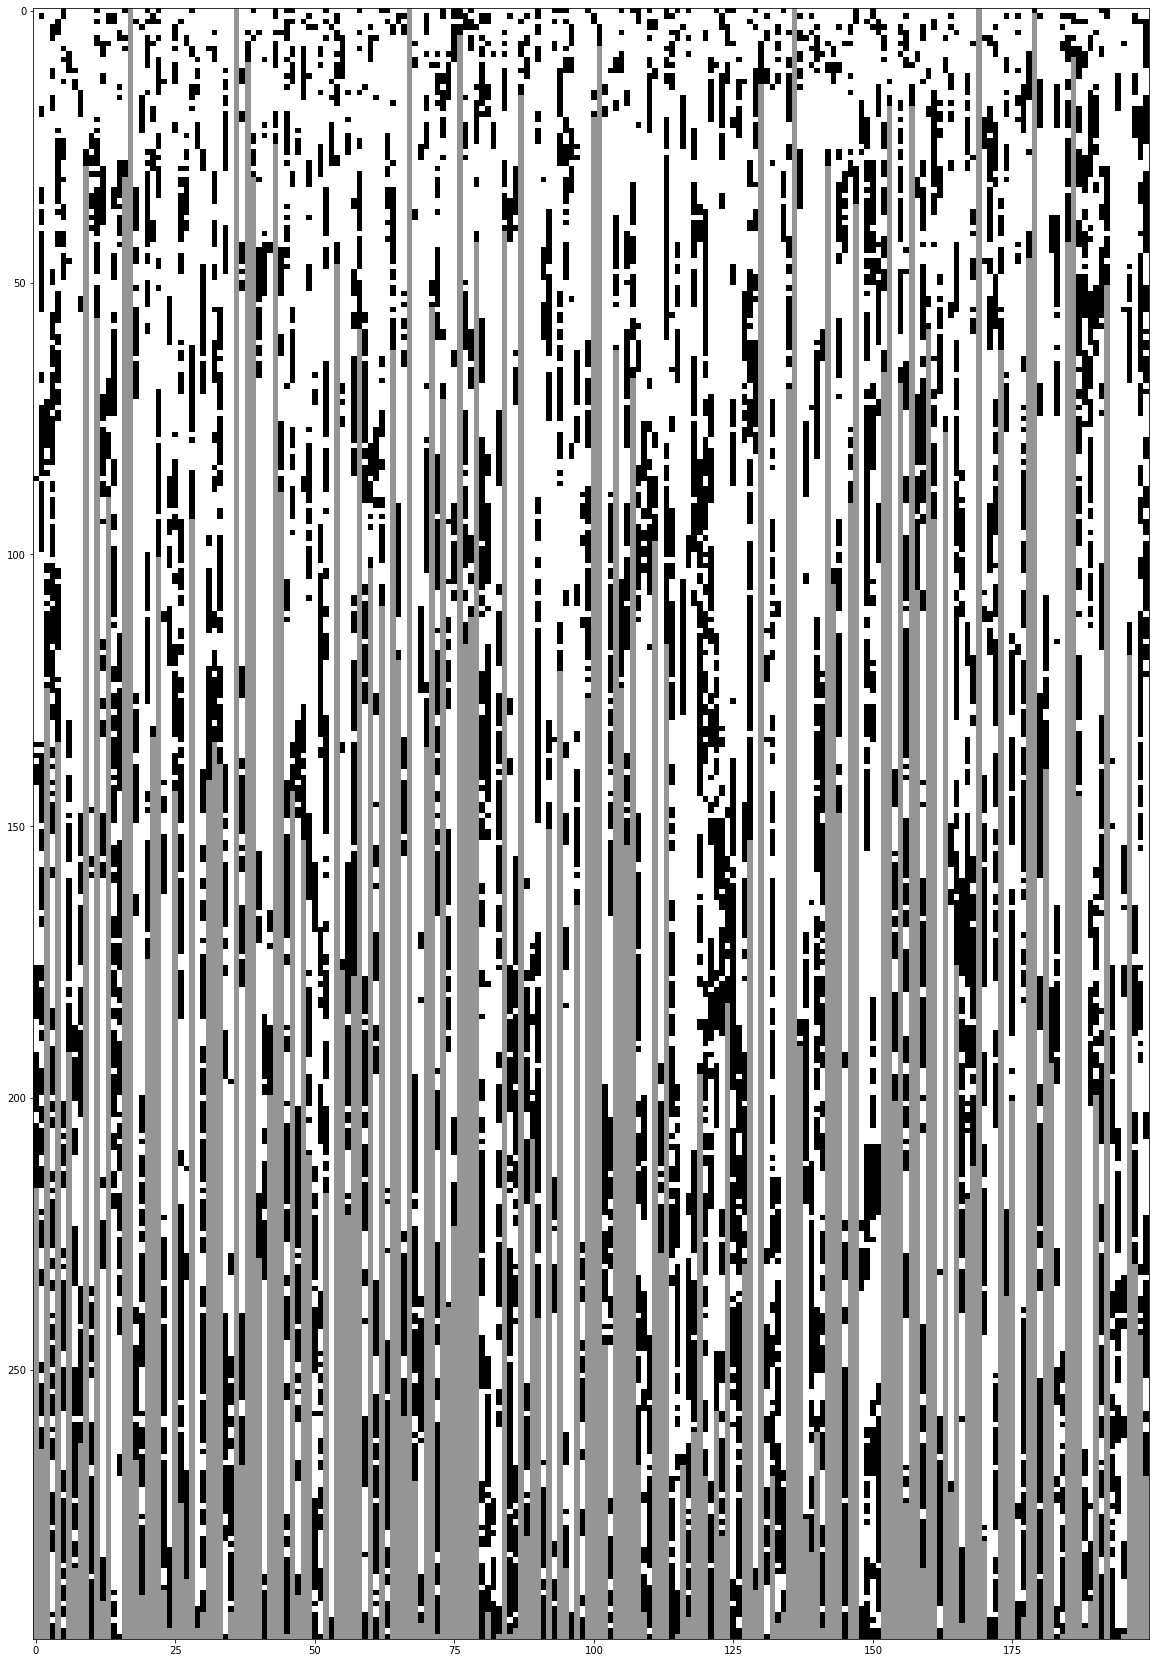

In [87]:
map_types = ["binary", "gradients"]
for i in range(len(drop_idxss)):
    print("Freq: %d iterations per update"%(iter_per_updates[i]))
    idx_heatmap(drop_idxss[i], D, "binary", False, True)
    #idx_heatmap(drop_idxss[i], D, "gradient", True)

# Times of update vs (test) Accuracy

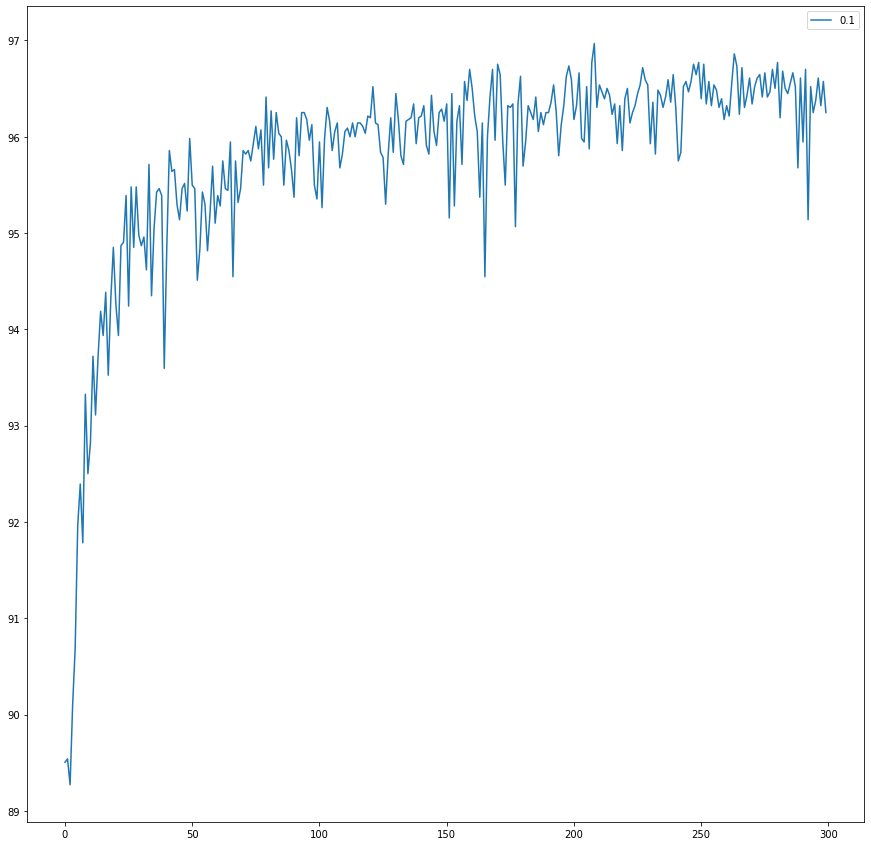

In [91]:
plt.figure(figsize = (15, 15))
sm_deg = 5 # Smoothness of curve, the higher the smoother. 1 = no smooth

for i,drop_accs  in enumerate (drop_accss):
    smoothed = [ np.max(drop_accs[sm_deg*i : sm_deg*(i+1)]) for i in range(len(drop_accs)//sm_deg) ]
    plt.plot( smoothed, label = str(percentDrops[i]))
plt.legend()
plt.show()

In [92]:
import xlsxwriter
workbook = xlsxwriter.Workbook('Dataset.xlsx')
worksheet = workbook.add_worksheet()

In [90]:
for i,drop_accs  in enumerate (drop_accss):
    smoothed = [ np.max(drop_accs[sm_deg*i : sm_deg*(i+1)]) for i in range(len(drop_accs)//sm_deg) ]
    for j, sm in enumerate(smoothed):
        worksheet.write(j, i, sm)
workbook.close()

# Change in Variance

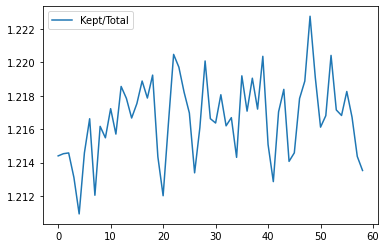

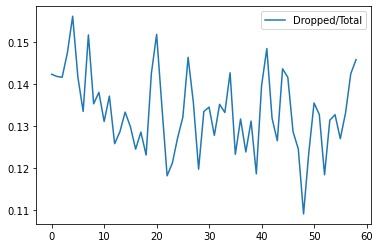

In [93]:
import xlsxwriter
workbook = xlsxwriter.Workbook('Averaged variance.xlsx')
worksheet2 = workbook.add_worksheet()


amountDrop = int(percentDrop * D)
sm_deg = 5
crop = 2000
scale = 2000

for i in range(len(kept_means)):
    drop_vars = (np.asarray(drop_varss[i])/amountDrop)
    kept_mean = (np.asarray(kept_means[i])/(D-amountDrop))
    summed = (np.asarray(drop_varss[i]) + np.asarray(kept_means[i]))/D
    

    
    accu = drop_accss[i]
    
    assert len(drop_vars) == len(kept_mean) == len(summed)
    
    sm_sum = [ np.mean(summed[sm_deg*i : sm_deg*(i+1)])    for i in range(len(summed)//sm_deg) ]
    sm_drp = [ np.mean(drop_vars[sm_deg*i : sm_deg*(i+1)]) for i in range(len(drop_vars)//sm_deg) ]
    sm_kpt = [ np.mean(kept_mean[sm_deg*i : sm_deg*(i+1)]) for i in range(len(kept_mean)//sm_deg) ]
    sm_acc = [ np.mean(accu[sm_deg*i * iter_per_update : sm_deg*(i+1)*iter_per_update]) for i in range(len(accu)//sm_deg//iter_per_update) ]
    
    # 0 is cropped for edge cases
    sm_sum = np.asarray(sm_sum[1:crop])
    sm_drp = np.asarray(sm_drp[1:crop])
    sm_kpt = np.asarray(sm_kpt[1:crop])
    sm_acc = np.asarray(sm_acc[1:crop])
    
    plt.plot(sm_kpt/sm_sum, label = "Kept/Total")
    plt.legend()
    plt.show()
    
    plt.plot(sm_drp/sm_sum, label = "Dropped/Total")
    plt.legend()
    plt.show()
    
    offset =  6*i
    worksheet2.write(0, offset + 0 , "Iteration")
    worksheet2.write(0, offset + 1 , "Total mean")
    worksheet2.write(0, offset + 2 , "Kept mean")
    worksheet2.write(0, offset + 3 , "Dropped mean")
    worksheet2.write(0, offset + 4 , "Accuracy")
    for j in range(len(sm_sum)):
        worksheet2.write(j+1, offset + 0 , j+1)
        worksheet2.write(j+1, offset + 1 , sm_sum[j])
        worksheet2.write(j+1, offset + 2 , sm_kpt[j])
        worksheet2.write(j+1, offset + 3 , sm_drp[j])
        worksheet2.write(j+1, offset + 4 , sm_acc[j])
workbook.close()

In [23]:
param['nFeatures']

312